In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot
import igraph
import scvelo as scv 
import loompy as lmp
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix 
import os 

In [2]:
sc.set_figure_params(facecolor= 'white', figsize= (8,8))
sc.settings.verbosity =3

In [7]:
adata= sc.datasets.visium_sge(sample_id= "V1_Mouse_Brain_Sagittal_Anterior")
adata.var_names_make_unique()

  0%|          | 0.00/8.81M [00:00<?, ?B/s]

  0%|          | 0.00/19.6M [00:00<?, ?B/s]

reading C:\Users\skeam\OneDrive - Inside MD Anderson\Genetic and genomic work__python workflow\Single cell project with python___\data\V1_Mouse_Brain_Sagittal_Anterior\filtered_feature_bc_matrix.h5
 (0:00:00)


In [8]:
adata

AnnData object with n_obs × n_vars = 2695 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
# QC and preprocessing 
adata.var["mt"]= adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars= ["mt"], inplace= True)

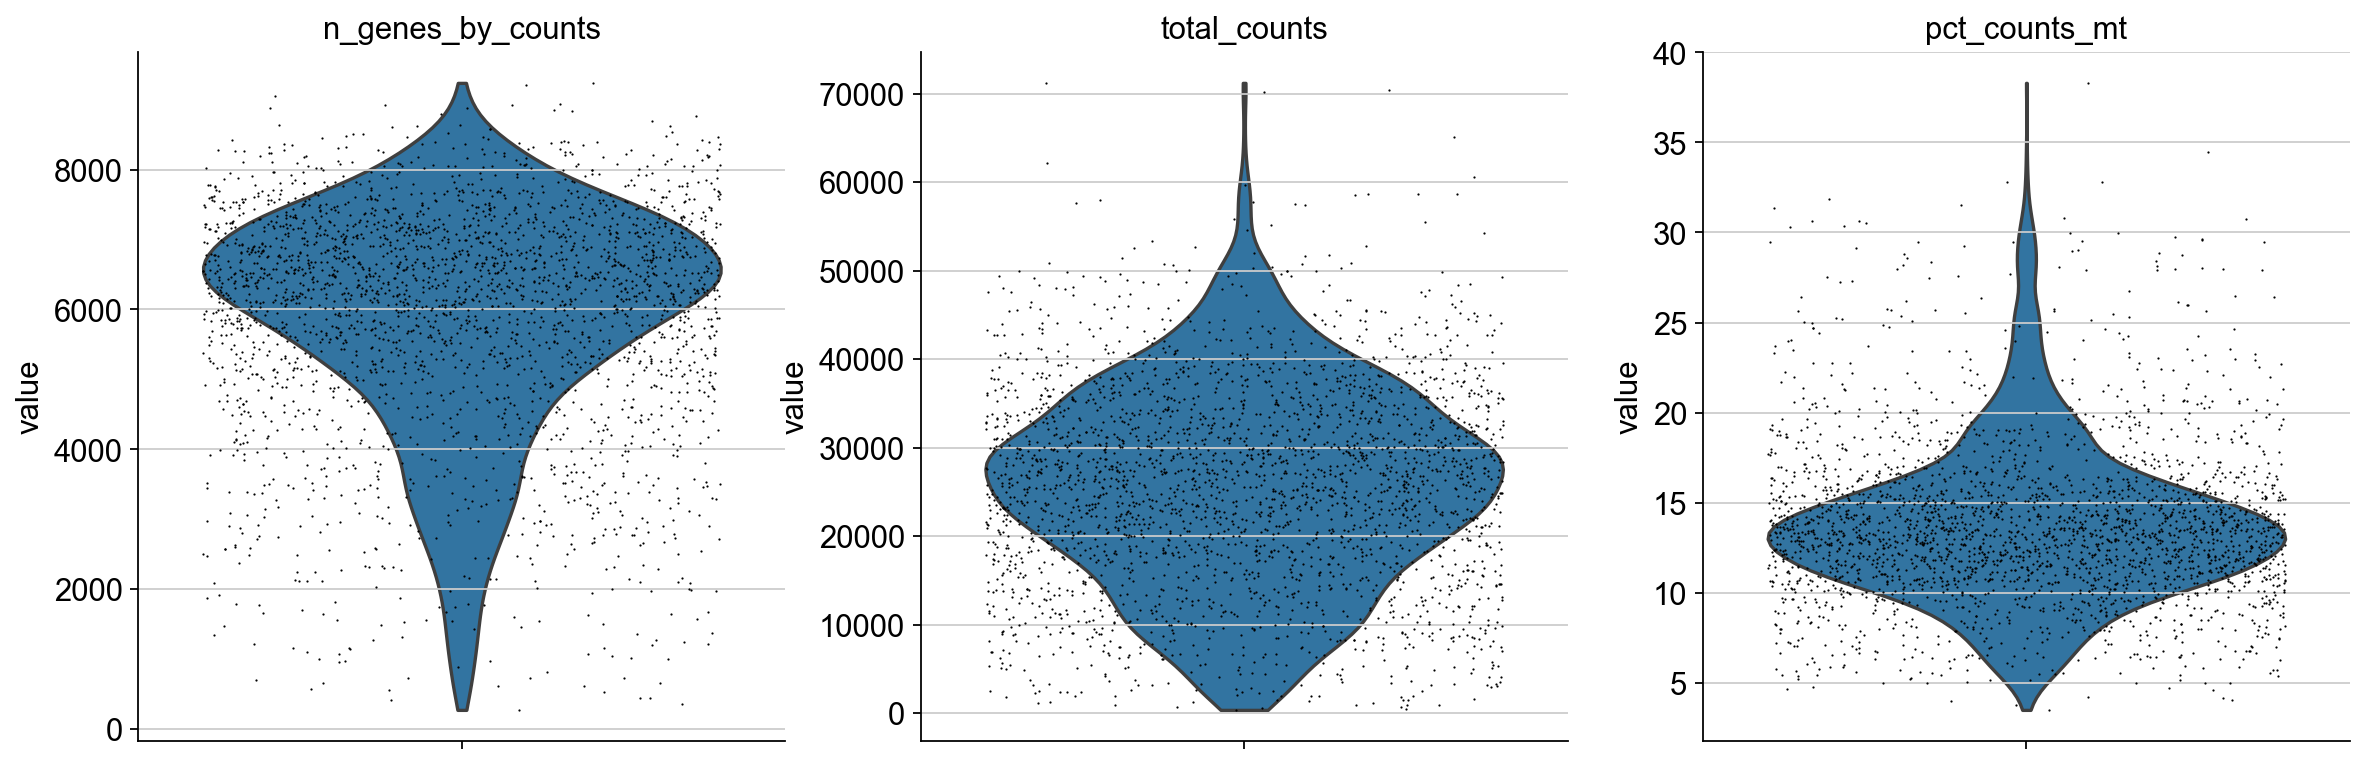

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
            jitter= 0.4, multi_panel= True)

In [11]:
adata= adata[adata.obs.n_genes_by_counts> 2000, :]
adata= adata[adata.obs.total_counts< 50000, :]
adata= adata[adata.obs.total_counts> 5000, :]
adata= adata[adata.obs.pct_counts_mt < 25, :]
sc.pp.filter_genes(adata, min_cells= 10)

filtered out 15250 genes that are detected in less than 10 cells


In [12]:
adata

AnnData object with n_obs × n_vars = 2500 × 17035
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
sc.pp.normalize_total(adata, inplace= True)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


In [14]:
sc.pp.highly_variable_genes(adata, flavor= "seurat", n_top_genes= 2000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [17]:
sc.tl.leiden(adata, key_added= 'clusters', resolution= .2)

running Leiden clustering
    finished: found 8 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


In [19]:
import matplotlib.pyplot as plt

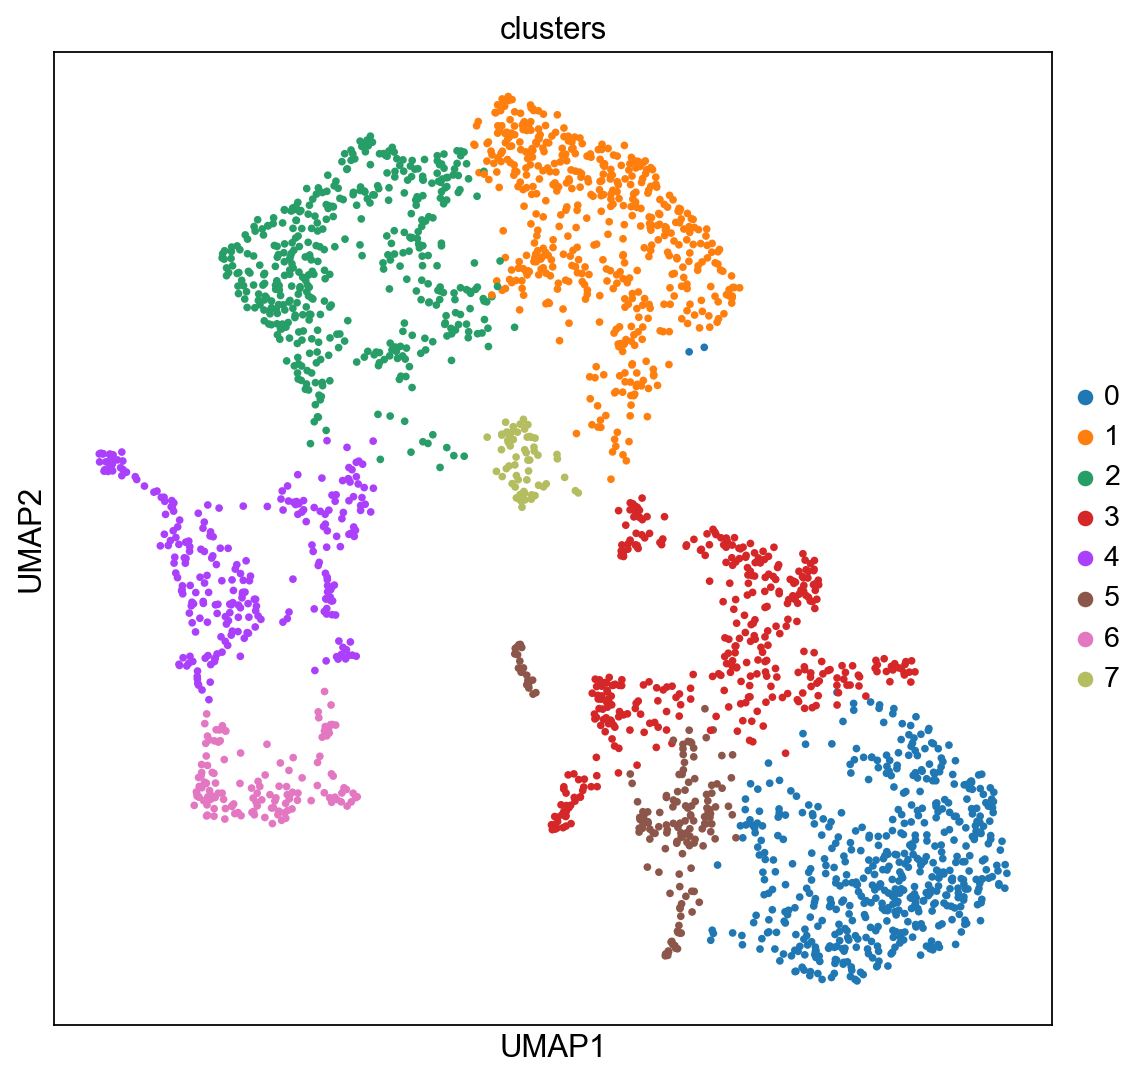

In [21]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.umap(adata, color= "clusters", wspace= 0.4)

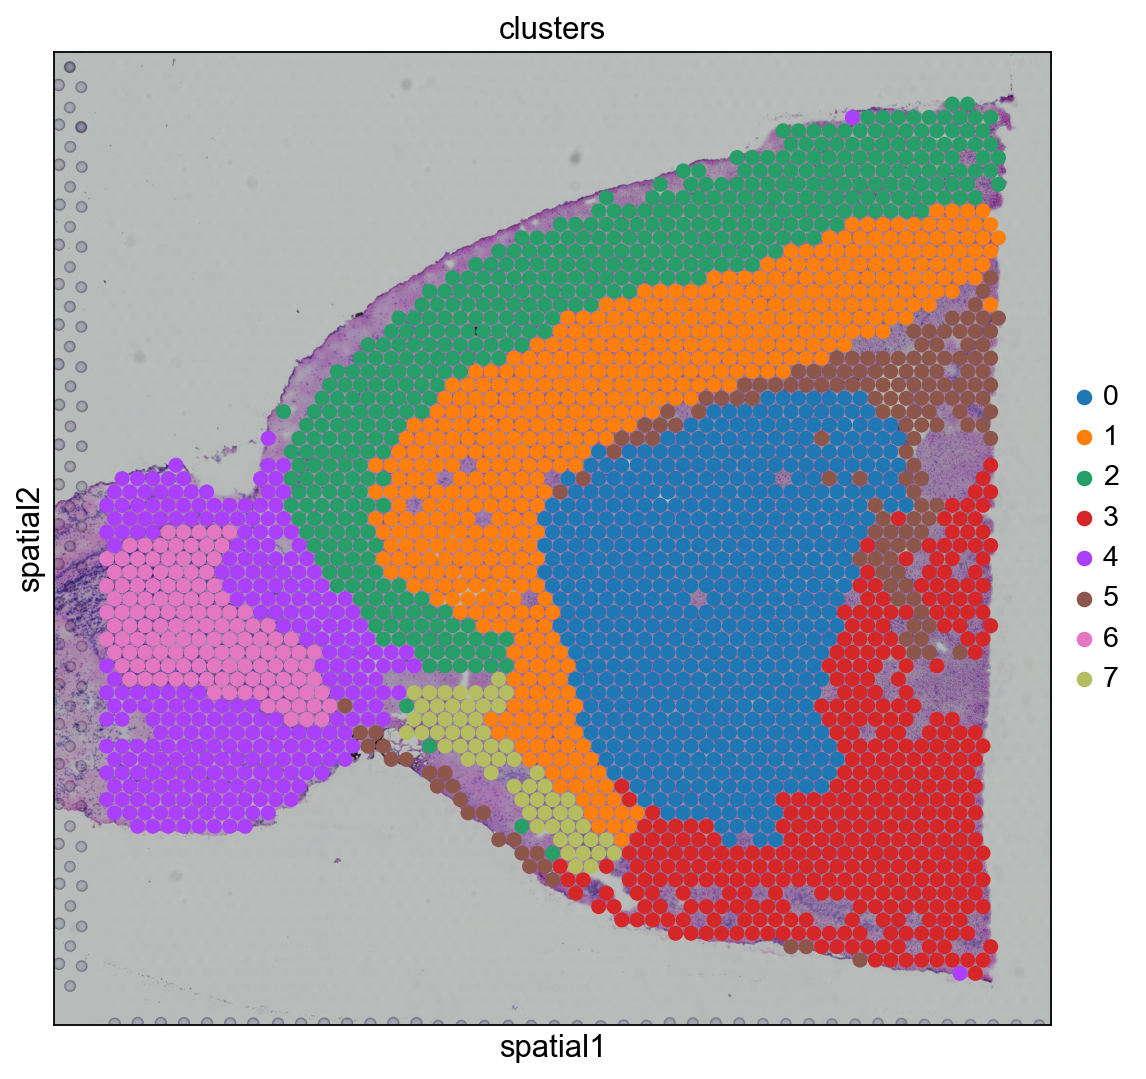

In [23]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key= "hires", color= 'clusters', size= 1.5)

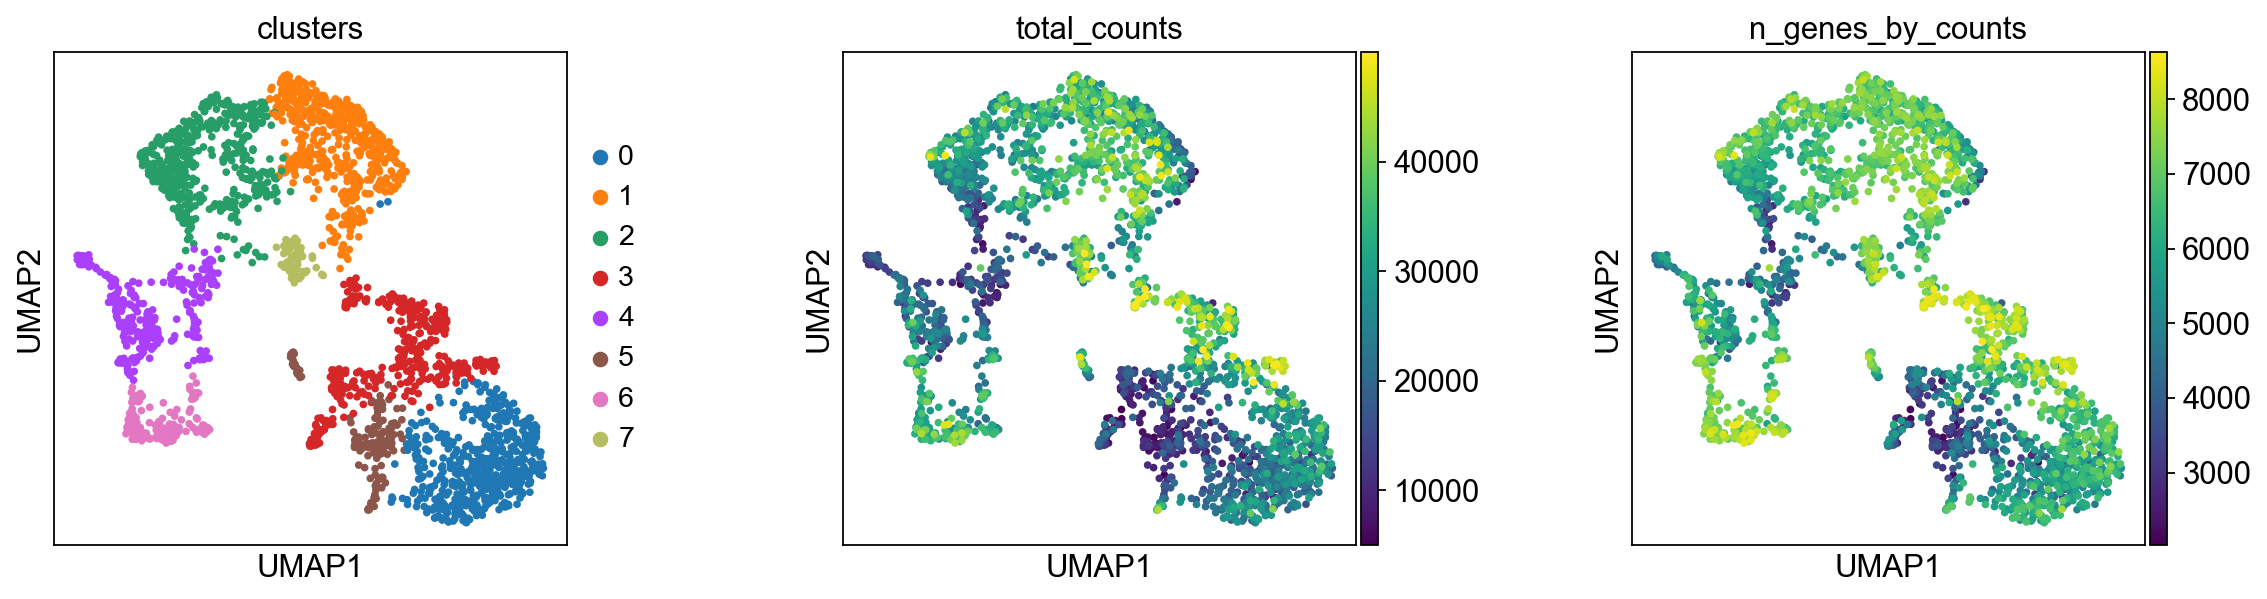

In [25]:
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.umap(adata, color= ["clusters", "total_counts", "n_genes_by_counts"], wspace= 0.4)

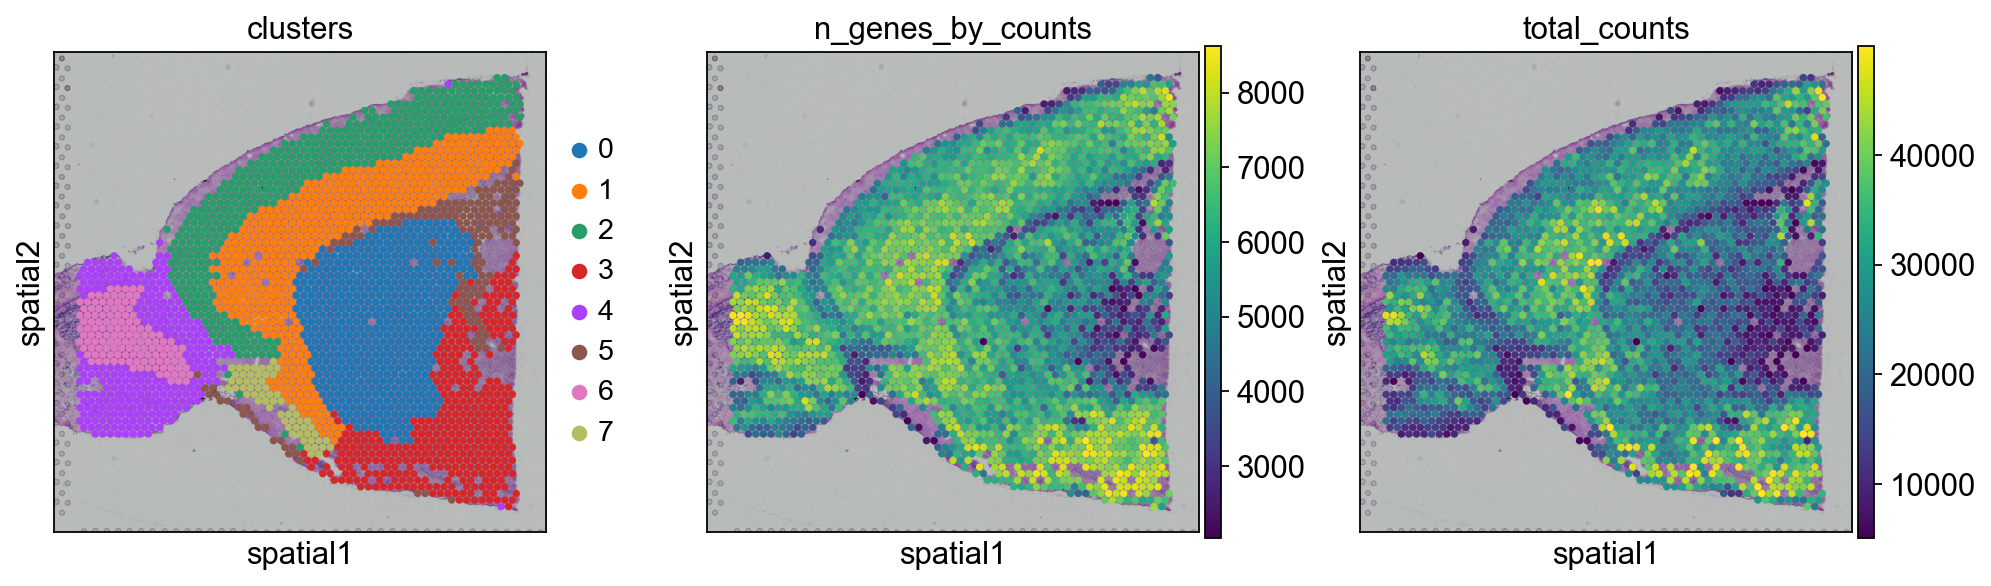

In [28]:
sc.pl.spatial(adata, img_key= "hires", color= ["clusters", "n_genes_by_counts", "total_counts"], size= 1.5)

In [29]:
sc.tl.rank_genes_groups(adata, "clusters", method= 'wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


In [30]:
sc.tl.rank_genes_groups(adata, "clusters", method= "wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`


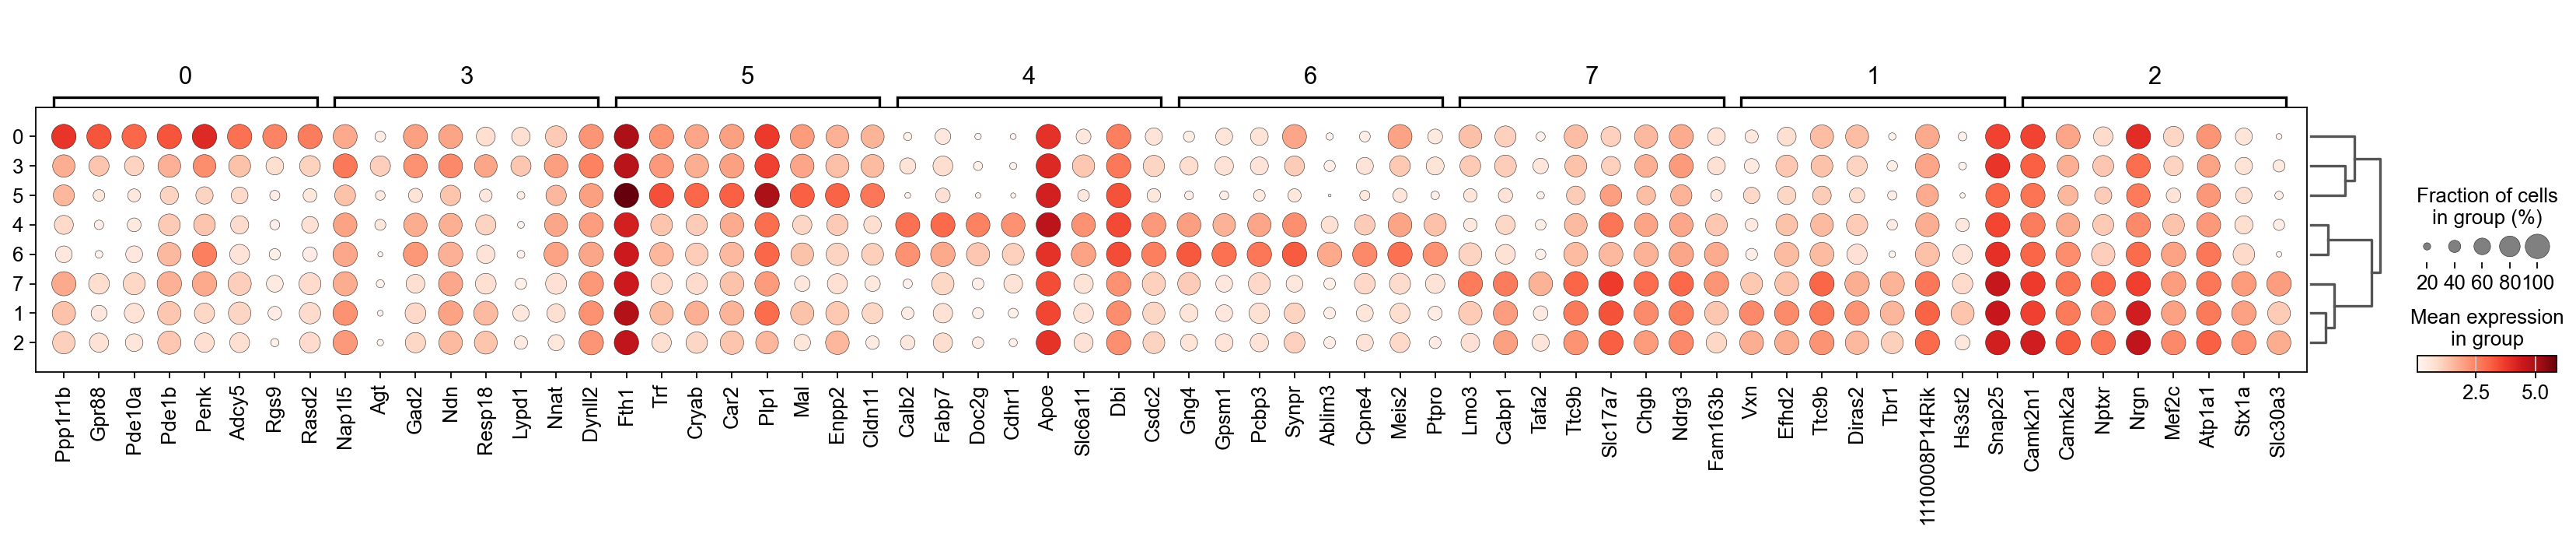

In [31]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes= 8)

categories: 0, 1, 2, etc.
var_group_labels: 5


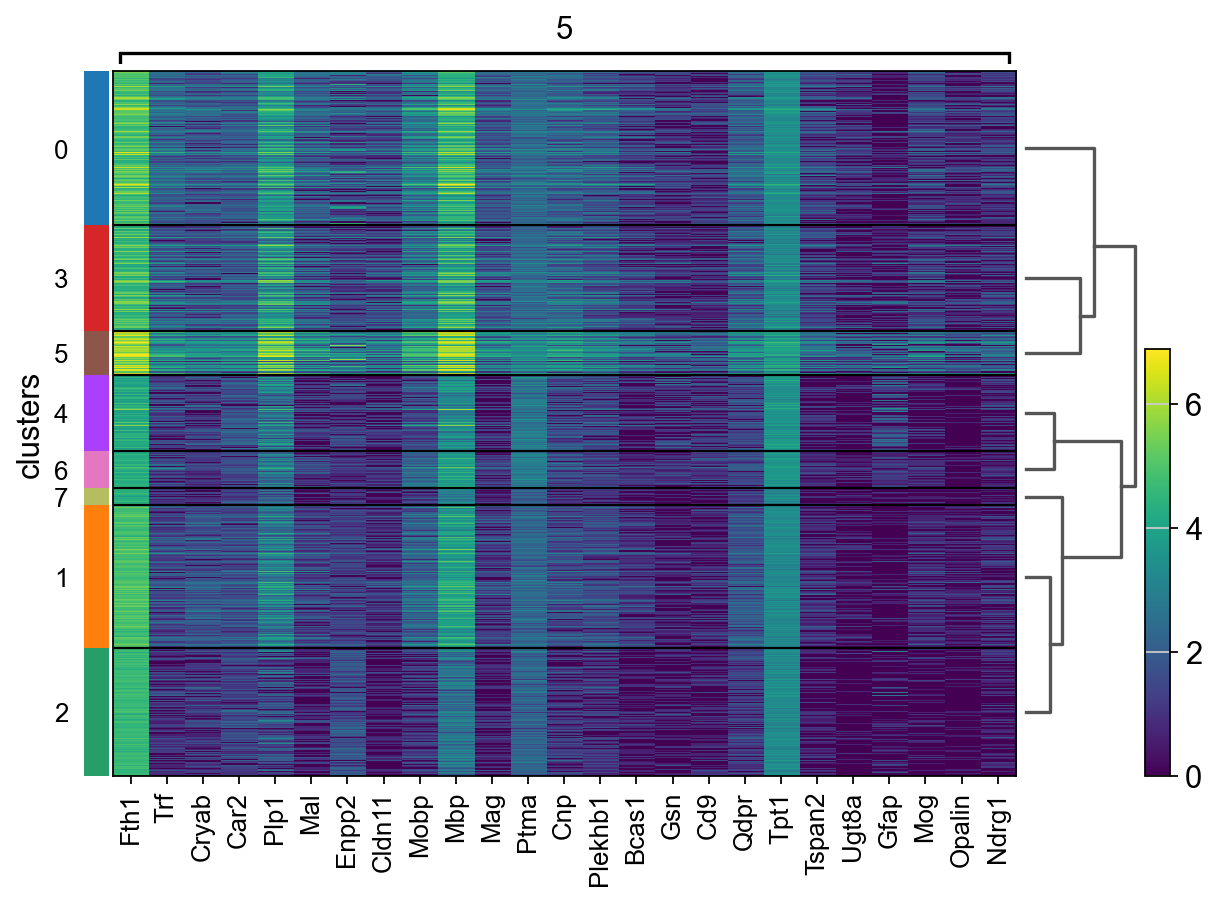

In [32]:
sc.pl.rank_genes_groups_heatmap(adata, groups= "5", n_genes= 25, groupby= "clusters")

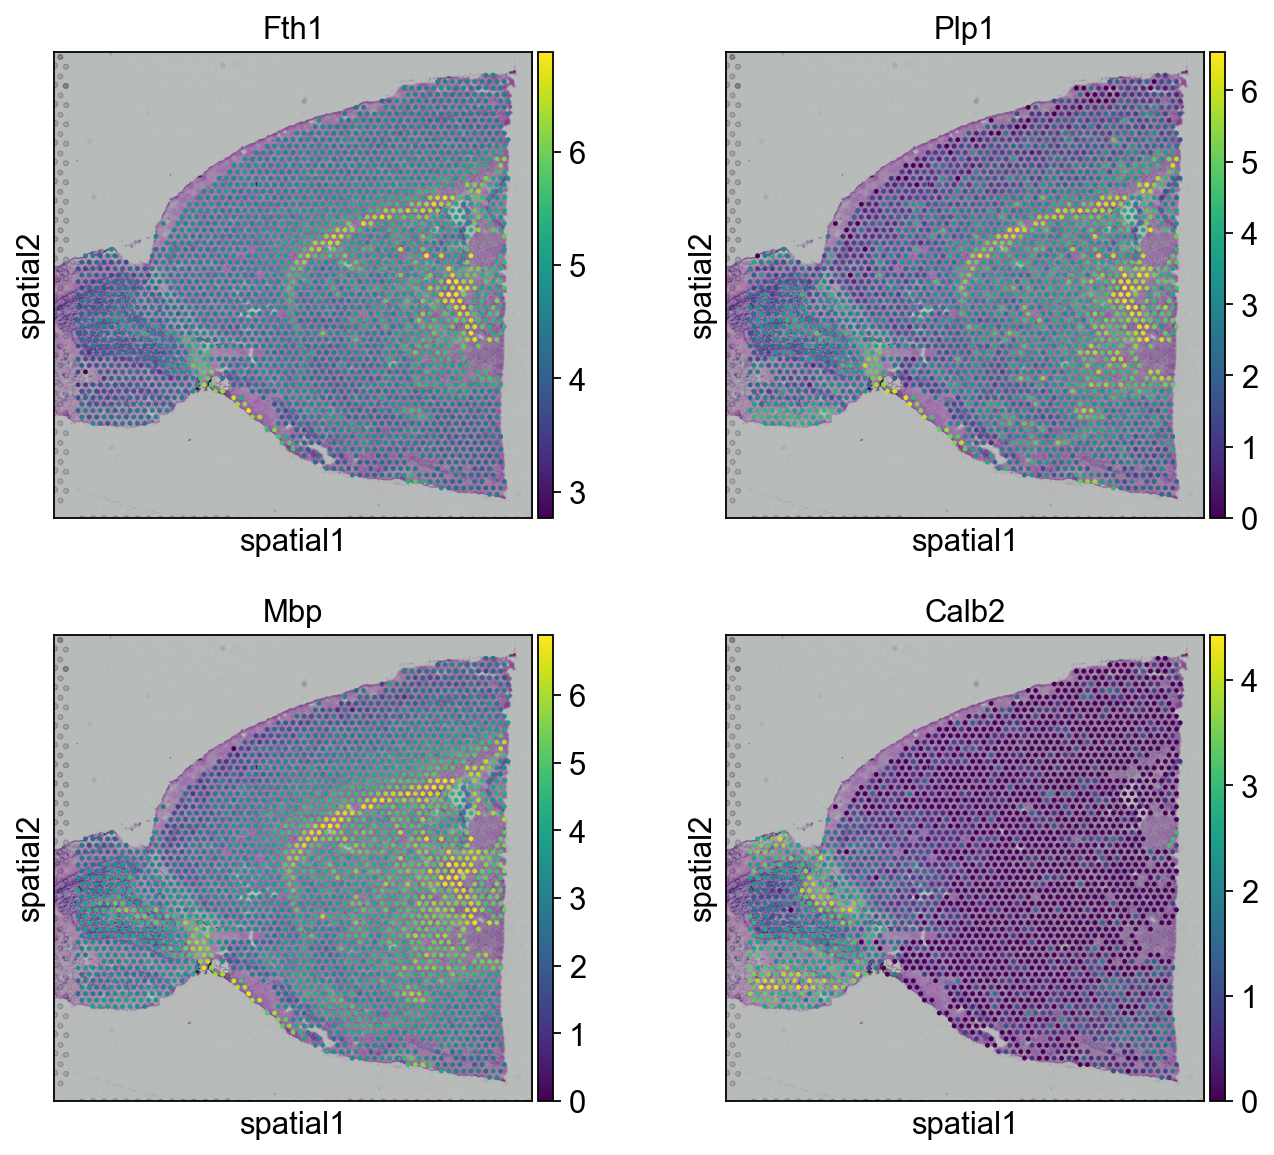

In [33]:
sc.pl.spatial(adata, img_key= "hires", color= ["Fth1", "Plp1", "Mbp", "Calb2"], ncols= 2)

In [35]:
#spatially variable genes
!pip install SpatialDE

  Obtaining dependency information for SpatialDE from https://files.pythonhosted.org/packages/a7/5a/ff529dc90a6adfd23f27fa302b50c703bf898d66059bf56b2e31c55ce762/SpatialDE-1.1.3-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for NaiveDE: filename=NaiveDE-1.2.0-py3-none-any.whl size=5703 sha256=f8649f94bf9ea51019f41ee1c501ef1e5adb04e001705644850cb12e8846a851
  Stored in directory: c:\users\skeam\appdata\local\pip\cache\wheels\5a\d9\6a\5d31ca0ef9362888a38bb5d2b7c6f15a1e5aacdfe1bc669afc
Successfully built NaiveDE


In [36]:
import SpatialDE

In [41]:
import pandas as pd
import numpy as np
import SpatialDE

# Convert adata.X to a NumPy array
counts_data = pd.DataFrame(adata.X.toarray(), columns=adata.var_names, index=adata.obs_names)

# Convert adata.obsm["spatial"] to a NumPy array
coord_data = pd.DataFrame(adata.obsm["spatial"], columns=['x_coord', 'y_coord'], index=adata.obs_names)

# Run SpatialDE
result = SpatialDE.run(coord_data.values, counts_data)

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/17035 [00:00<?, ?it/s]

  0%|          | 0/17035 [00:00<?, ?it/s]

  0%|          | 0/17035 [00:00<?, ?it/s]

  0%|          | 0/17035 [00:00<?, ?it/s]

  0%|          | 0/17035 [00:00<?, ?it/s]

  0%|          | 0/17035 [00:00<?, ?it/s]

  0%|          | 0/17035 [00:00<?, ?it/s]

  0%|          | 0/17035 [00:00<?, ?it/s]

  0%|          | 0/17035 [00:00<?, ?it/s]

  0%|          | 0/17035 [00:00<?, ?it/s]

In [45]:
#concatenate the results with the DataFrame of annotations of variables:adata
result.index= result["g"]
adata.var= pd.concat([adata.var, result.loc[adata.var.index, :]], axis= 1)

In [46]:
#inspect signficant genes that varies in space 
result.sort_values("qval").head(10)

FSV  M       g           l  max_delta       max_ll  max_mu_hat  \
g                                                                             
Itpr1   0.532272  4   Itpr1  454.696506   0.855516 -1951.383557    1.590436   
Tbc1d9  0.142626  4  Tbc1d9  454.696506   5.852485 -2119.534766    0.710655   
Gab1    0.192488  4    Gab1  454.696506   4.084271 -1812.301790    0.402191   
Rasd2   0.603525  4   Rasd2  454.696506   0.639570 -2154.098638    1.033582   
Large1  0.170686  4  Large1  454.696506   4.730298 -2113.443681    0.978972   
Unc13a  0.243486  4  Unc13a  454.696506   3.024898 -2119.963245    1.171300   
Abhd8   0.216089  4   Abhd8  454.696506   3.531843 -1891.048260    1.786144   
Rpl18a  0.231822  4  Rpl18a  454.696506   3.226087  -324.549535    3.111424   
Mast3   0.328217  4   Mast3  454.696506   1.992675 -2119.812602    1.317283   
Rab3a   0.545563  4   Rab3a  454.696506   0.810955 -1168.492277    2.907599   

        max_s2_t_hat model     n    s2_FSV  s2_logdelta      time  \
g                                                                   
Itpr1       0.319153    SE  2500  0.000025     0.000466  0.003991   
Tbc1d9      0.058541    SE  2500  0.000023     0.001403  0.004973   
Gab1        0.058813    SE  2500  0.000031     0.001258  0.005066   
Rasd2       0.443689    SE  2500  0.000018     0.000359  0.004049   
Large1      0.076942    SE  2500  0.000028     0.001350  0.004973   
Unc13a      0.117832    SE  2500  0.000037     0.001135  0.004899   
Abhd8       0.119224    SE  2500  0.000034     0.001191  0.003978   
Rpl18a      0.175341    SE  2500  0.000027     0.000870  0.004979   
Mast3       0.171076    SE  2500  0.000035     0.000797  0.007046   
Rab3a       0.300355    SE  2500  0.000030     0.000575  0.002992   

                BIC  max_ll_null          LLR  pval  qval  
g                                                          
Itpr1   3934.063298 -2942.432156   991.048599   0.0   0.0  
Tbc1d9  4270.365716 -2256.319525   136.784759   0.0   0.0  
Gab1    3655.899764 -1979.426788   167.124998   0.0   0.0  
Rasd2   4339.493460 -3430.828408  1276.729770   0.0   0.0  
Large1  4258.183547 -2288.881445   175.437764   0.0   0.0  
Unc13a  4271.222674 -2361.974051   242.010806   0.0   0.0  
Abhd8   3813.392704 -2136.533774   245.485514   0.0   0.0  
Rpl18a   680.395255  -593.888933   269.339397   0.0   0.0  
Mast3   4270.921388 -2469.386751   349.574150   0.0   0.0  
Rab3a   2368.280738 -1691.014259   522.521982   0.0   0.0

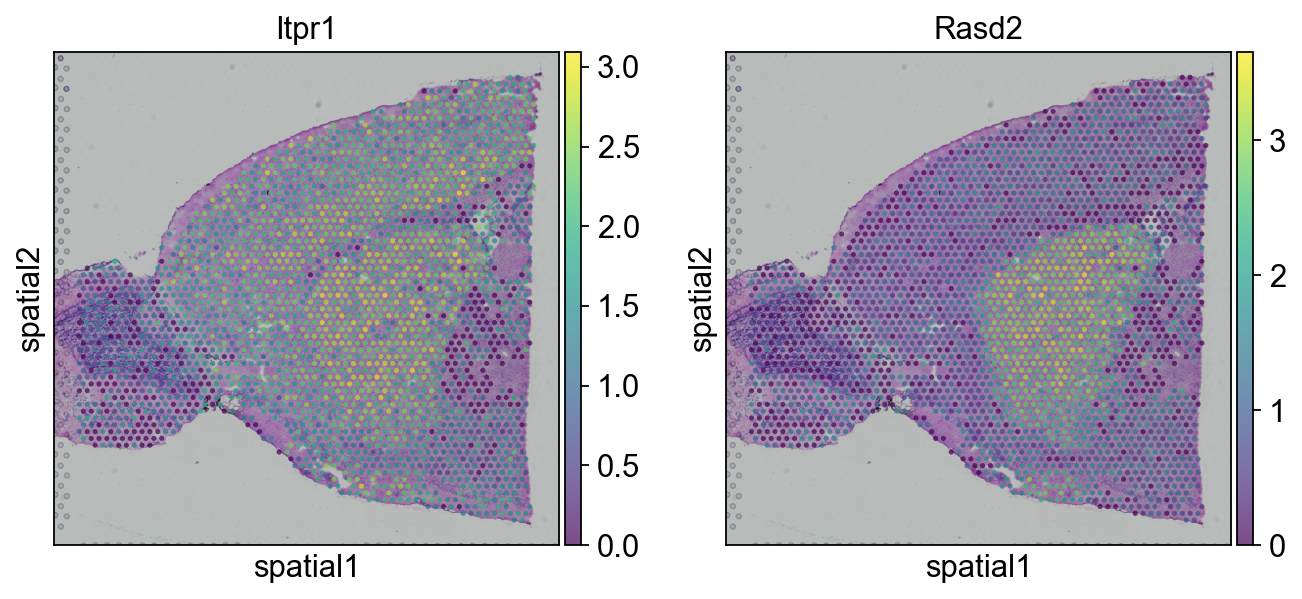

In [47]:
# Visualize signficant genes using sc.pl.spatial function
sc.pl.spatial(adata, img_key= "hires", color= ["Itpr1", "Rasd2"], alpha=0.7)